In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.linear_model import LinearRegression

**Rappels de fonctionnement d'une loi gaussienne**  
norm.pdf(x, mu, sigma) donne la densité de probabilité pour chaque valeur de x  
norm.cdf(x, mu, sigma) donne la probabilité cumulée jusqu’à la valeur x  


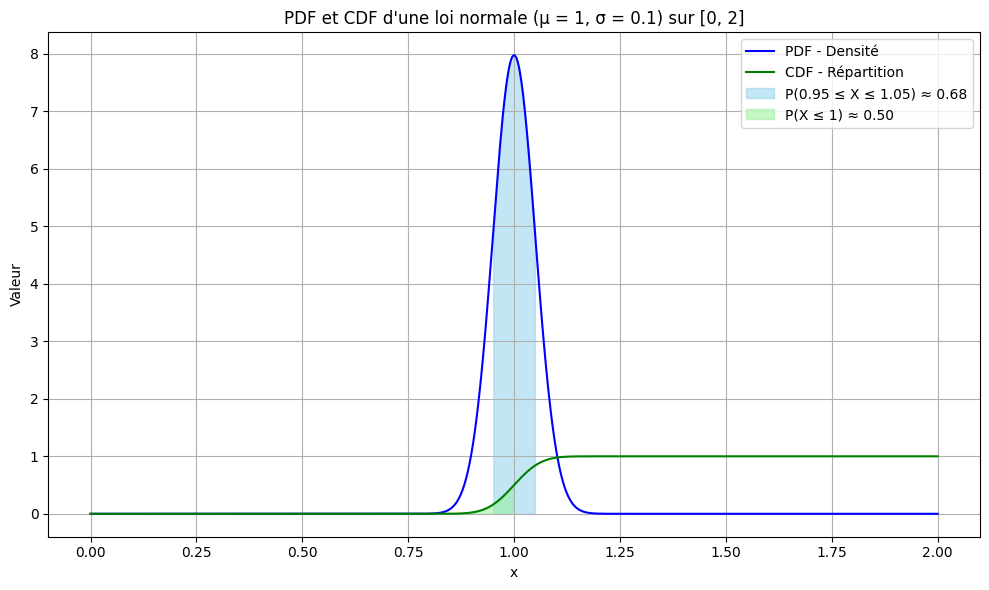

In [2]:
mu = 1
sigma = 0.05 # pour rappel, 68% des valeurs de retrouvent [mu - sigma ; mu + sigma]
x = np.linspace(0, 2, 1000)

# PDF et CDF
pdf = norm.pdf(x, mu, sigma)
cdf = norm.cdf(x, mu, sigma)

a = 0.95
b = 1.05

x_max = 1
p_x_max = norm.cdf(x_max, mu, sigma)

plt.figure(figsize=(10, 6))
plt.plot(x, pdf, label='PDF - Densité', color='blue')
plt.plot(x, cdf, label='CDF - Répartition', color='green')
plt.fill_between(x, pdf, where = (x >= a) & (x <= b), 
                 color='skyblue', alpha=0.5,
                 label=f"P({a} ≤ X ≤ {b}) ≈ {norm.cdf(b, mu, sigma) - norm.cdf(a, mu, sigma):.2f}")
plt.fill_between(x, cdf, where = (x <= x_max), 
                 color='lightgreen', alpha=0.5,
                 label=f"P(X ≤ {x_max}) ≈ {p_x_max:.2f}")

plt.title("PDF et CDF d'une loi normale (μ = 1, σ = 0.1) sur [0, 2]")
plt.xlabel("x")
plt.ylabel("Valeur")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

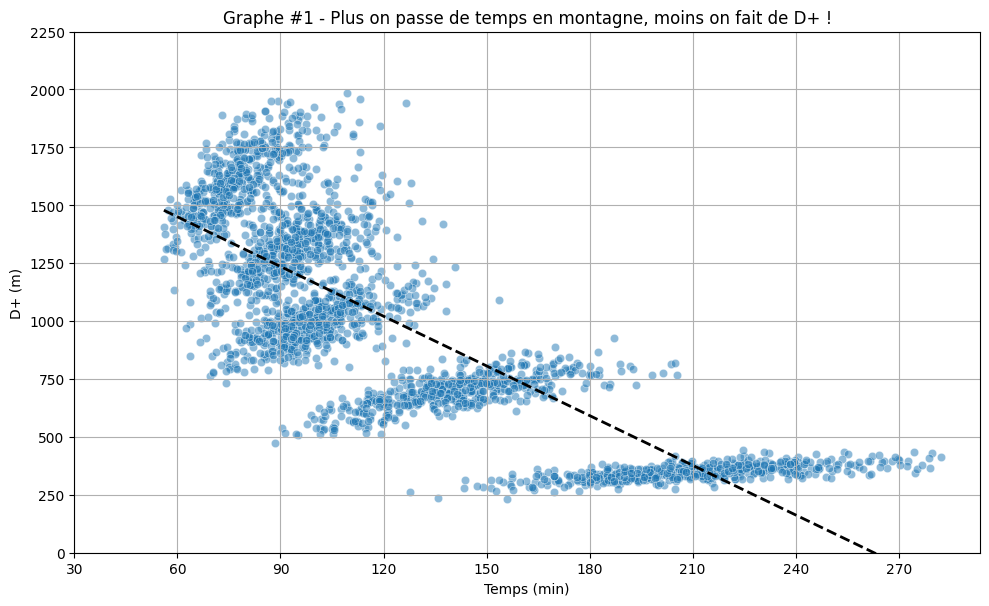

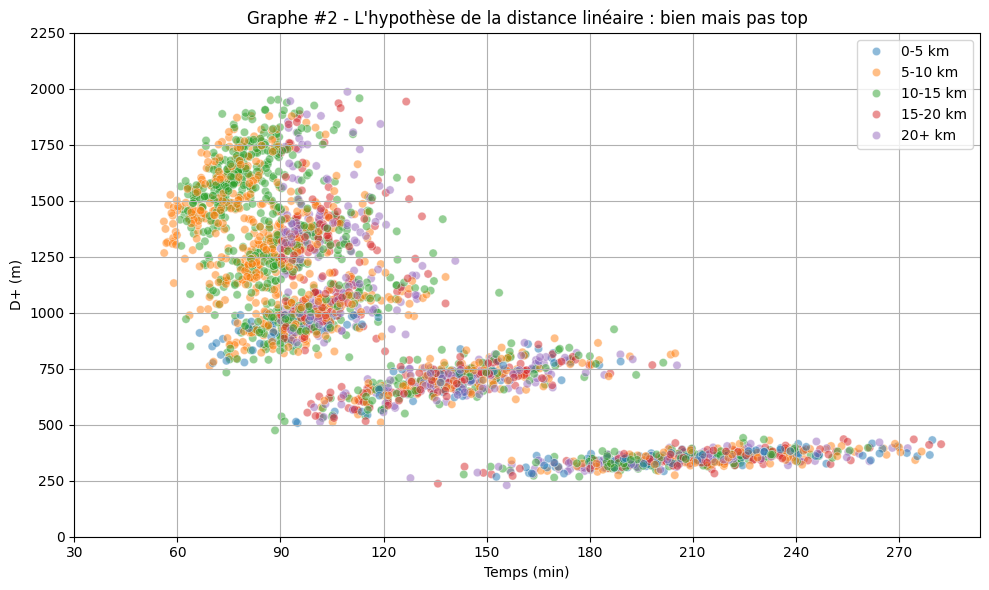

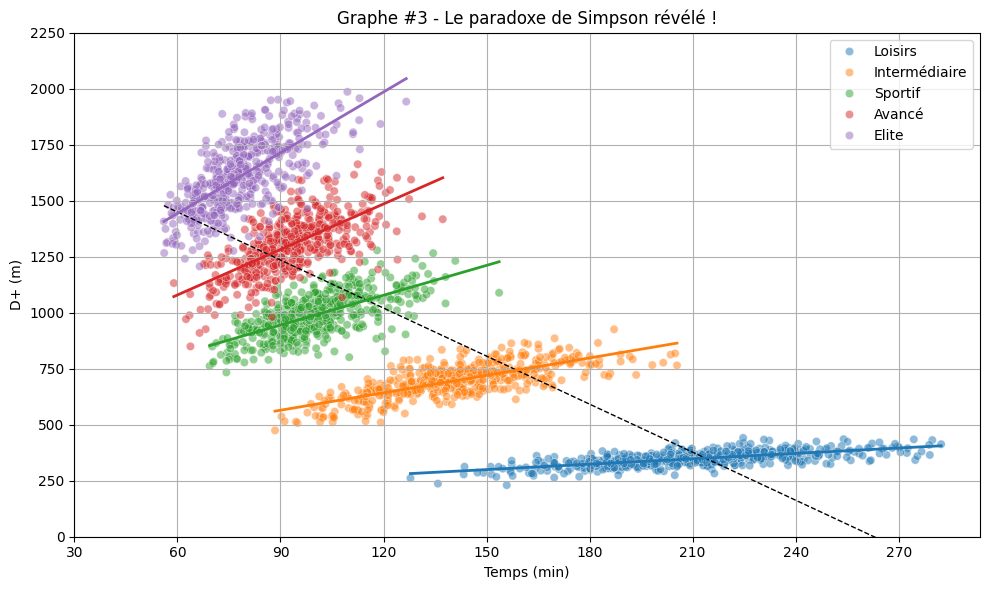

In [5]:
n = 500

groups = {
    "Loisirs":       {"avg_deniv": 350,  "asc_speed": 100,  "sigma_deniv": 35, "sigma_asc_speed": 10},
    "Intermédiaire": {"avg_deniv": 700,  "asc_speed": 300,  "sigma_deniv": 70, "sigma_asc_speed": 30},
    "Sportif":       {"avg_deniv": 1000, "asc_speed": 600,  "sigma_deniv": 100, "sigma_asc_speed": 60},
    "Avancé":        {"avg_deniv": 1300, "asc_speed": 850,  "sigma_deniv": 130, "sigma_asc_speed": 85},
    "Elite":         {"avg_deniv": 1600, "asc_speed": 1250, "sigma_deniv": 160, "sigma_asc_speed": 125}
}

data = []

for profil, params in groups.items():
    deniv = np.random.normal(params["avg_deniv"], params["sigma_deniv"], size=n)
    speed_asc = np.random.normal(params["asc_speed"], params["sigma_asc_speed"], size=n)
    temps = deniv / speed_asc * 60
    for denivele, t in zip(deniv, temps):
        is_data_consistent = False
        match profil:

            # garde-fou pour les données si on force la variance du tirage aléatoiree
            case "Loisirs":
                if 0 < denivele < 700 and 60 < t < 300:
                    is_data_consistent = True
            case "Intermédiaire":
                if 350 < denivele < 1000 and 0 < t:
                    is_data_consistent = True
            case "Sportif":
                if 500 < denivele < 1500 and 0 < t:
                    is_data_consistent = True
            case "Avancé":
                if 700 < denivele < 2000 and 0 < t:
                    is_data_consistent = True
            case "Elite":
                if 1200 < denivele < 2500 and 0 < t:
                    is_data_consistent = True 
            case _:      
                pass

        # lorsque la donnée est cohérente, on lui attribue une distance linéaire de manière aléatoire mais plausible           
        if is_data_consistent:
            # 5km min pour 1000+ D+
            if denivele > 2500:
                dist_min = 12.5   
            elif denivele > 2000:
                dist_min = 10
            elif denivele > 1500:
                dist_min = 7.5   
            elif denivele > 1000:
                dist_min = 5
            elif denivele > 500:
                dist_min = 2.5   
            else:
                dist_min = 0
            # vitesse linéaire max de 10 km/h    
            if t < 60:
                dist_max = 10
            elif t < 90:
                dist_max = 15
            else:
                dist_max = 25
            distance = np.random.uniform(dist_min, dist_max)
            data.append([profil, denivele, t, distance])

df = pd.DataFrame(data, columns=["Profil", "Dénivelée (m)", "Temps (min)", "Distance (km)"])

# rajout de la distance linéaire par catégorie
def categoriser_distance(dist):
    if dist > 20:
        return "20+ km"
    elif dist > 15:
        return "15-20 km"
    elif dist > 10:
        return "10-15 km"
    if dist > 5:
        return "5-10 km"
    else:
        return "0-5 km"
df["Cat. Distance"] = df["Distance (km)"].apply(categoriser_distance)

# 1er graphe pour montrer la tendance générale avec une régression globale
# "Plus on met de temps, moins on fait de dénivelé"
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="Temps (min)", y="Dénivelée (m)", alpha=0.5)
X = df[["Temps (min)"]]
y = df["Dénivelée (m)"]
model = LinearRegression().fit(X, y)
x_vals = np.linspace(df["Temps (min)"].min(), df["Temps (min)"].max(), 500)
x_vals_df = pd.DataFrame(x_vals, columns=["Temps (min)"])
y_vals = model.predict(x_vals_df)
plt.plot(x_vals, y_vals, color="black", linestyle="--", linewidth=2)
plt.xlabel("Temps (min)")
plt.ylabel("D+ (m)")
plt.xticks(np.arange(30, 300, 30))
plt.yticks(np.arange(0, 2500, 250))
plt.ylim(bottom=0)
plt.grid(True)
plt.tight_layout()
plt.title("Graphe #1 - Plus on passe de temps en montagne, moins on fait de D+ !")
plt.show()

# 2eme graphe pour montrer que ce n'est pas la distance des randonnées en cause
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="Temps (min)", y="Dénivelée (m)", hue="Cat. Distance", hue_order = ["0-5 km", "5-10 km", "10-15 km", "15-20 km", "20+ km"], alpha=0.5)
plt.xlabel("Temps (min)")
plt.ylabel("D+ (m)")
plt.xticks(np.arange(30, 300, 30))
plt.yticks(np.arange(0, 2500, 250))
plt.ylim(bottom=0)
plt.grid(True)
plt.title("Graphe #2 - L'hypothèse de la distance linéaire : bien mais pas top")
plt.tight_layout()
plt.gca().legend(title=None)
plt.show()

# 3eme graphe : la révélation avec le paradoxe de Simpson
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="Temps (min)", y="Dénivelée (m)", hue="Profil", alpha=0.5)
X = df[["Temps (min)"]]
y = df["Dénivelée (m)"]
model = LinearRegression().fit(X, y)
pente_m_par_min = model.coef_[0]
pente_m_par_h = pente_m_par_min * 60
x_vals = np.linspace(df["Temps (min)"].min(), df["Temps (min)"].max(), 500)
x_vals_df = pd.DataFrame(x_vals, columns=["Temps (min)"])
y_vals = model.predict(x_vals_df)
plt.plot(x_vals, y_vals, color="black", linestyle="--", linewidth=1)
for profil in df["Profil"].unique():
    subset = df[df["Profil"] == profil]
    X_sub = subset[["Temps (min)"]]
    y_sub = subset["Dénivelée (m)"]
    model_sub = LinearRegression().fit(X_sub, y_sub)
    x_range = np.linspace(X_sub.min(), X_sub.max(), 500)
    y_pred = model_sub.predict(pd.DataFrame(x_range, columns=["Temps (min)"]))
    plt.plot(x_range, y_pred, linewidth=2)
plt.xlabel("Temps (min)")
plt.ylabel("D+ (m)")
plt.xticks(np.arange(30, 300, 30))
plt.yticks(np.arange(0, 2500, 250))
plt.ylim(bottom=0)
plt.grid(True)
plt.title("Graphe #3 - Le paradoxe de Simpson révélé !")
plt.legend()
plt.tight_layout()
plt.show()